## 1. Setup and Dependencies
importing the required libraries and setting up our environment:

In [2]:
import os
import math
import time
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Data Loading and Preprocessing
custom dataset class that combines MNIST and FashionMNIST:

In [3]:
class CombinedMNISTDataset(Dataset):
    """
    Dataset that combines MNIST and FashionMNIST datasets.
    MNIST labels are 0-9, FashionMNIST labels are shifted to 10-19.
    """

    def __init__(self, root='./data', train=True, transform=None, download=True):
        """
        Initialize the combined dataset.

        Args:
            root (str): Directory to store the dataset
            train (bool): If True, use the training set, otherwise use test set
            transform (callable): Optional transform to be applied on a sample
            download (bool): If True, download the dataset if not already downloaded
        """
        self.transform = transform or transforms.ToTensor()

        # Get MNIST
        mnist = datasets.MNIST(root=root, train=train, download=download, transform=None)

        # Get FashionMNIST
        fashion_mnist = datasets.FashionMNIST(root=root, train=train, download=download, transform=None)

        # Convert data to appropriate format
        mnist_data = mnist.data.unsqueeze(1).float() / 255.0  # Add channel dimension and normalize
        fashion_data = fashion_mnist.data.unsqueeze(1).float() / 255.0

        # Combine data
        self.data = torch.cat([mnist_data, fashion_data])

        # Combine targets, shifting FashionMNIST by 10
        self.targets = torch.cat([
            mnist.targets,
            fashion_mnist.targets + 10
        ])

        # Save class names
        self.class_names = [
            # MNIST (0-9)
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
            # FashionMNIST (10-19)
            'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, target = self.data[idx], int(self.targets[idx])

        # Apply transforms if specified
        if self.transform is not None:
            img = self.transform(img)

        return img, target

100%|██████████| 9.91M/9.91M [00:10<00:00, 909kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.50MB/s]
100%|██████████| 26.4M/26.4M [00:02<00:00, 9.23MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 168kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.13MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.1MB/s]


Number of training samples: 120000
Number of validation samples: 20000
Number of classes: 20
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


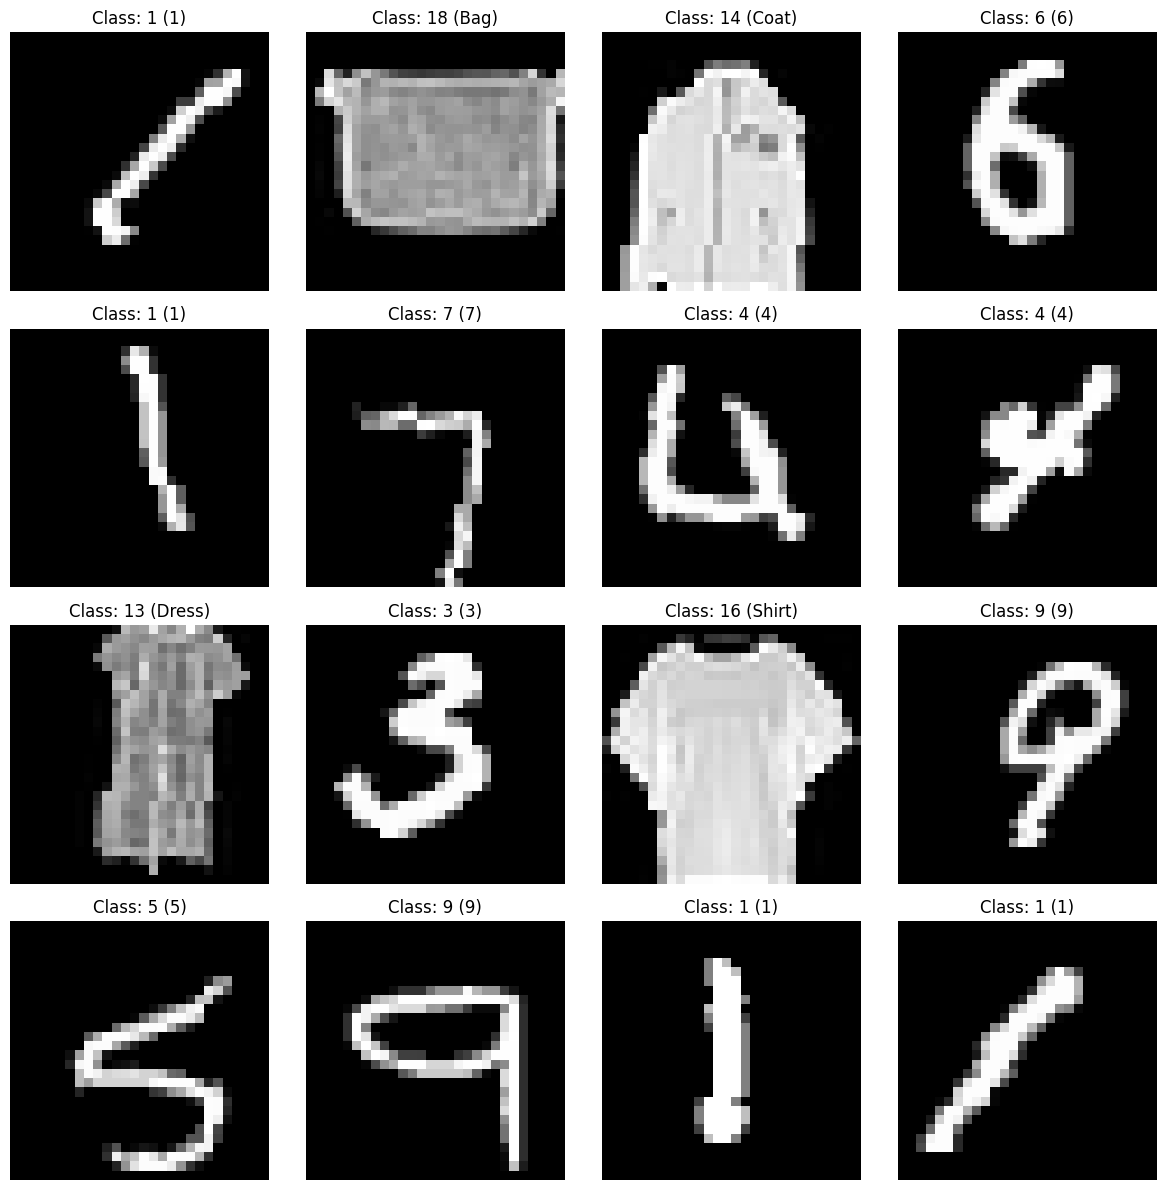

In [4]:
def get_transforms():
    """Define transforms for training and validation"""
    # For training: add some augmentations
    train_transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # For validation/testing: just normalize
    val_transform = transforms.Compose([
        transforms.Normalize((0.5,), (0.5,))
    ])

    return train_transform, val_transform

def get_dataloaders(batch_size=64, num_workers=2):
    """Create dataloaders for train and validation sets"""
    train_transform, val_transform = get_transforms()

    # Create datasets
    train_dataset = CombinedMNISTDataset(
        root='./data',
        train=True,
        transform=train_transform,
        download=True
    )

    val_dataset = CombinedMNISTDataset(
        root='./data',
        train=False,
        transform=val_transform,
        download=True
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader, train_dataset.class_names

# Create dataloaders
train_loader, val_loader, class_names = get_dataloaders()

# Display info about the dataset
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")

# Visualize a few samples
def show_batch(dataloader, n_samples=16, n_cols=4):
    """Visualize a batch of images"""
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    n_rows = (n_samples + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))

    for i, ax in enumerate(axes.flat):
        if i < n_samples:
            img = images[i].squeeze().numpy()
            label = int(labels[i])
            ax.imshow(img, cmap='gray')
            ax.set_title(f"Class: {label} ({class_names[label]})")
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Show a batch of training images
show_batch(train_loader)

## 3. Model Architecture
Implement our SimpleVisionGPT model, which adapts the nanoGPT architecture for vision tasks:

In [5]:
# LayerNorm implementation similar to nanoGPT
class LayerNorm(nn.Module):
    """LayerNorm with optional bias"""
    def __init__(self, ndim, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class PatchEmbedding(nn.Module):
    """
    Image to Patch Embedding layer.
    Similar to ViT's approach, it divides an image into patches and embeds them.
    """
    def __init__(self, img_size=28, patch_size=4, in_channels=1, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        # Linear projection from patches to embedding dimension
        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # CLS token for classification
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Position embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, self.n_patches + 1, embed_dim))
        nn.init.normal_(self.pos_embed, std=0.02)

    def forward(self, x):
        """
        Forward pass of the patch embedding.
        Args:
            x: Input images of shape (B, C, H, W)
        Returns:
            Embedded patches of shape (B, n_patches + 1, embed_dim)
        """
        B = x.shape[0]

        # Extract patches and project them
        x = self.proj(x)  # (B, embed_dim, H//patch_size, W//patch_size)
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)

        # Add class token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Add position embedding
        x = x + self.pos_embed

        return x

class MultiHeadAttention(nn.Module):
    """
    Simple multi-head attention for vision tasks (no causal mask).
    """
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0

        # Key, query, value projections
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)

        # Output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        # Regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)

        # Dimensions
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.head_dim = config.n_embd // config.n_head
        self.dropout = config.dropout

        # Flash attention for efficiency if available
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')

    def forward(self, x):
        B, T, C = x.size()  # batch, sequence length, embedding dimensionality

        # Calculate query, key, values
        qkv = self.c_attn(x)
        q, k, v = qkv.chunk(3, dim=-1)

        # Reshape for multi-head attention
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)  # (B, nh, T, hs)
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)  # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)  # (B, nh, T, hs)

        # Compute attention
        if self.flash:
            # Use efficient flash attention (no causal mask for vision)
            y = torch.nn.functional.scaled_dot_product_attention(
                q, k, v,
                attn_mask=None,
                dropout_p=self.dropout if self.training else 0,
                is_causal=False
            )
        else:
            # Manual implementation
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        # Reshape and project back
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))

        return y

class Block(nn.Module):
    """
    Transformer block for vision tasks.
    """
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = MultiHeadAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

class VisionGPTConfig:
    """
    Configuration class for VisionGPT.
    """
    def __init__(self, **kwargs):
        # Vision-specific parameters
        self.img_size = 28  # Default for MNIST/FashionMNIST
        self.patch_size = 4
        self.in_channels = 1
        self.n_classes = 20  # 10 for MNIST + 10 for FashionMNIST

        # Model parameters
        self.n_layer = 6
        self.n_head = 8
        self.n_embd = 256
        self.dropout = 0.1
        self.bias = True

        # Calculate block_size based on image size and patch size
        self.block_size = (self.img_size // self.patch_size) ** 2 + 1  # +1 for cls token

        # Override defaults with kwargs
        for k, v in kwargs.items():
            setattr(self, k, v)

class VisionGPT(nn.Module):
    """
    VisionGPT model: an adaptation of nanoGPT for vision tasks.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config

        # Patch embedding
        self.patch_embed = PatchEmbedding(
            img_size=config.img_size,
            patch_size=config.patch_size,
            in_channels=config.in_channels,
            embed_dim=config.n_embd
        )

        # Dropout
        self.drop = nn.Dropout(config.dropout)

        # Transformer blocks
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])

        # Final layer norm
        self.ln_f = LayerNorm(config.n_embd, bias=config.bias)

        # Classification head
        self.head = nn.Linear(config.n_embd, config.n_classes, bias=False)

        # Initialize weights
        self.apply(self._init_weights)

        # Apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # Report number of parameters
        print(f"Number of parameters: {self.get_num_params()/1e6:.2f}M")

    def get_num_params(self):
        """Return the number of parameters in the model."""
        return sum(p.numel() for p in self.parameters())

    def _init_weights(self, module):
        """Initialize weights similarly to the original GPT model."""
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def forward(self, x, targets=None):
        """
        Forward pass of the model.
        Args:
            x: Input images of shape (B, C, H, W)
            targets: Optional target labels for computing the loss
        Returns:
            logits: Classification logits
            loss: Loss value if targets are provided, else None
        """
        # Get patch embeddings
        x = self.patch_embed(x)  # (B, n_patches + 1, n_embd)

        # Apply dropout
        x = self.drop(x)

        # Forward through all transformer blocks
        for block in self.blocks:
            x = block(x)

        # Apply final layer norm
        x = self.ln_f(x)

        # Classification head (use only the CLS token)
        logits = self.head(x[:, 0])  # Only use the CLS token for classification

        # Calculate loss if targets are provided
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits, targets)

        return logits, loss

# Create model configuration and instantiate the model
model_config = VisionGPTConfig(
    img_size=28,
    patch_size=4,
    in_channels=1,
    n_layer=6,
    n_head=8,
    n_embd=256,
    dropout=0.1,
    bias=True,
    n_classes=20
)

model = VisionGPT(model_config).to(device)

Number of parameters: 4.76M


## 4. Training Pipeline
set up our training pipeline, including the optimizer and learning rate scheduler:

In [6]:
def configure_optimizer(model, weight_decay=0.01, learning_rate=3e-4, betas=(0.9, 0.95)):
    """Configure the optimizer for the model."""
    # Create parameter groups with weight decay
    param_dict = {pn: p for pn, p in model.named_parameters() if p.requires_grad}

    # Parameters with dimension >= 2 get weight decay, others don't
    decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
    nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]

    optim_groups = [
        {'params': decay_params, 'weight_decay': weight_decay},
        {'params': nodecay_params, 'weight_decay': 0.0}
    ]

    num_decay_params = sum(p.numel() for p in decay_params)
    num_nodecay_params = sum(p.numel() for p in nodecay_params)

    print(f"Decay parameters: {len(decay_params)}, with {num_decay_params:,} parameters")
    print(f"No-decay parameters: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")

    # Create AdamW optimizer
    optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas)
    return optimizer

def get_cosine_lr_scheduler(optimizer, warmup_iters=500, max_iters=5000, min_lr=3e-5):
    """Get a learning rate scheduler with warmup and cosine decay."""
    def lr_lambda(iter_num):
        # Linear warmup
        if iter_num < warmup_iters:
            return float(iter_num) / float(max(1, warmup_iters))
        # Cosine decay
        decay_ratio = (iter_num - warmup_iters) / (max_iters - warmup_iters)
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
        return min_lr + coeff * (1.0 - min_lr)

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Set up optimizer and scheduler
learning_rate = 3e-4
weight_decay = 0.01
betas = (0.9, 0.95)
warmup_iters = 500
max_iters = 5000
min_lr = 3e-5

optimizer = configure_optimizer(
    model,
    weight_decay=weight_decay,
    learning_rate=learning_rate,
    betas=betas
)

scheduler = get_cosine_lr_scheduler(
    optimizer,
    warmup_iters=warmup_iters,
    max_iters=max_iters,
    min_lr=min_lr
)

# Training and evaluation functions
@torch.no_grad()
def evaluate(model, dataloader, device, num_batches=None):
    """Evaluate the model on the given dataloader"""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    batches = dataloader
    if num_batches is not None:
        batches = [next(iter(dataloader)) for _ in range(num_batches)]

    for batch in batches:
        images, targets = batch
        images = images.to(device)
        targets = targets.to(device)

        logits, loss = model(images, targets)
        preds = torch.argmax(logits, dim=-1)

        total_loss += loss.item() * len(targets)
        total_correct += (preds == targets).sum().item()
        total_samples += len(targets)

    avg_loss = total_loss / total_samples
    accuracy = 100 * total_correct / total_samples

    model.train()
    return avg_loss, accuracy

def train_epoch(model, dataloader, optimizer, scheduler, device, log_interval=10):
    """Train the model for one epoch"""
    model.train()
    running_loss = 0
    running_acc = 0
    count = 0

    pbar = tqdm(dataloader, leave=False)
    for i, (images, targets) in enumerate(pbar):
        images = images.to(device)
        targets = targets.to(device)

        # Forward pass
        logits, loss = model(images, targets)

        # Compute accuracy
        preds = torch.argmax(logits, dim=-1)
        acc = (preds == targets).float().mean().item() * 100

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Optimize
        optimizer.step()
        scheduler.step()

        # Update metrics
        running_loss += loss.item()
        running_acc += acc
        count += 1

        # Update progress bar
        pbar.set_description(f"Loss: {loss.item():.4f}, Acc: {acc:.2f}%")

        # Log every log_interval batches
        if (i + 1) % log_interval == 0:
            print(f"Batch {i+1}/{len(dataloader)}: Loss: {running_loss/count:.4f}, Acc: {running_acc/count:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}")
            running_loss = 0
            running_acc = 0
            count = 0

def train(model, train_loader, val_loader, optimizer, scheduler, device,
          n_epochs=10, eval_interval=1, log_interval=10, save_dir='./checkpoints'):
    """Train the model for n_epochs"""

    # Create directory for checkpoints
    os.makedirs(save_dir, exist_ok=True)

    # Track best model
    best_val_loss = float('inf')

    # Track metrics
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    lr_values = []

    # Initial evaluation
    val_loss, val_acc = evaluate(model, val_loader, device)
    print(f"Initial validation: Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Training loop
    total_batches = len(train_loader) * n_epochs
    global_step = 0

    for epoch in range(n_epochs):
        print(f"Epoch {epoch+1}/{n_epochs}")

        # Train for one epoch
        train_epoch(model, train_loader, optimizer, scheduler, device, log_interval)

        # Evaluate
        train_loss, train_acc = evaluate(model, train_loader, device, num_batches=50)
        val_loss, val_acc = evaluate(model, val_loader, device)

        # Track metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        lr_values.append(scheduler.get_last_lr()[0])

        # Print results
        print(f"Epoch {epoch+1}/{n_epochs}:")
        print(f"  Train loss: {train_loss:.4f}, accuracy: {train_acc:.2f}%")
        print(f"  Val loss: {val_loss:.4f}, accuracy: {val_acc:.2f}%")
        print(f"  Learning rate: {scheduler.get_last_lr()[0]:.6f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
                'config': vars(model.config),
            }
            torch.save(checkpoint, os.path.join(save_dir, 'best_model.pt'))
            print(f"  New best model saved with val loss: {val_loss:.4f}")

        # Save latest model
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'config': vars(model.config),
        }
        torch.save(checkpoint, os.path.join(save_dir, 'latest_model.pt'))

        global_step += len(train_loader)

    # Return training metrics
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'lr_values': lr_values
    }

Decay parameters: 28, with 4,740,864 parameters
No-decay parameters: 51, with 20,736 parameters


## 5. Model Training

Initial validation: Loss: 3.0348, Acc: 3.46%
Epoch 1/5


  0%|          | 0/1875 [00:00<?, ?it/s]

Batch 10/1875: Loss: 3.0248, Acc: 4.53%, LR: 0.000006
Batch 20/1875: Loss: 2.9562, Acc: 7.50%, LR: 0.000012
Batch 30/1875: Loss: 2.8755, Acc: 8.28%, LR: 0.000018
Batch 40/1875: Loss: 2.8075, Acc: 11.25%, LR: 0.000024
Batch 50/1875: Loss: 2.6974, Acc: 11.72%, LR: 0.000030
Batch 60/1875: Loss: 2.6083, Acc: 14.38%, LR: 0.000036
Batch 70/1875: Loss: 2.5755, Acc: 17.97%, LR: 0.000042
Batch 80/1875: Loss: 2.4787, Acc: 17.34%, LR: 0.000048
Batch 90/1875: Loss: 2.4659, Acc: 16.72%, LR: 0.000054
Batch 100/1875: Loss: 2.4082, Acc: 19.06%, LR: 0.000060
Batch 110/1875: Loss: 2.3550, Acc: 19.69%, LR: 0.000066
Batch 120/1875: Loss: 2.2770, Acc: 22.19%, LR: 0.000072
Batch 130/1875: Loss: 2.3281, Acc: 21.25%, LR: 0.000078
Batch 140/1875: Loss: 2.2660, Acc: 16.25%, LR: 0.000084
Batch 150/1875: Loss: 2.3349, Acc: 16.25%, LR: 0.000090
Batch 160/1875: Loss: 2.2462, Acc: 20.78%, LR: 0.000096
Batch 170/1875: Loss: 2.2160, Acc: 21.41%, LR: 0.000102
Batch 180/1875: Loss: 2.2111, Acc: 19.84%, LR: 0.000108
Batc

  0%|          | 0/1875 [00:00<?, ?it/s]

Batch 10/1875: Loss: 0.7706, Acc: 71.09%, LR: 0.000235
Batch 20/1875: Loss: 0.7814, Acc: 71.25%, LR: 0.000234
Batch 30/1875: Loss: 0.6983, Acc: 73.91%, LR: 0.000233
Batch 40/1875: Loss: 0.7792, Acc: 71.09%, LR: 0.000233
Batch 50/1875: Loss: 0.7612, Acc: 72.66%, LR: 0.000232
Batch 60/1875: Loss: 0.7309, Acc: 73.28%, LR: 0.000231
Batch 70/1875: Loss: 0.7460, Acc: 73.91%, LR: 0.000230
Batch 80/1875: Loss: 0.7411, Acc: 73.59%, LR: 0.000229
Batch 90/1875: Loss: 0.7031, Acc: 72.66%, LR: 0.000228
Batch 100/1875: Loss: 0.6653, Acc: 74.06%, LR: 0.000227
Batch 110/1875: Loss: 0.6998, Acc: 74.38%, LR: 0.000226
Batch 120/1875: Loss: 0.7197, Acc: 74.06%, LR: 0.000225
Batch 130/1875: Loss: 0.7412, Acc: 73.59%, LR: 0.000225
Batch 140/1875: Loss: 0.7520, Acc: 72.81%, LR: 0.000224
Batch 150/1875: Loss: 0.7382, Acc: 71.88%, LR: 0.000223
Batch 160/1875: Loss: 0.6442, Acc: 75.31%, LR: 0.000222
Batch 170/1875: Loss: 0.7328, Acc: 75.94%, LR: 0.000221
Batch 180/1875: Loss: 0.7445, Acc: 75.00%, LR: 0.000220
B

  0%|          | 0/1875 [00:00<?, ?it/s]

Batch 10/1875: Loss: 0.4806, Acc: 83.44%, LR: 0.000053
Batch 20/1875: Loss: 0.4517, Acc: 83.91%, LR: 0.000052
Batch 30/1875: Loss: 0.4813, Acc: 83.75%, LR: 0.000051
Batch 40/1875: Loss: 0.4959, Acc: 81.25%, LR: 0.000050
Batch 50/1875: Loss: 0.4363, Acc: 84.06%, LR: 0.000050
Batch 60/1875: Loss: 0.4743, Acc: 82.81%, LR: 0.000049
Batch 70/1875: Loss: 0.4588, Acc: 81.72%, LR: 0.000048
Batch 80/1875: Loss: 0.4316, Acc: 84.06%, LR: 0.000047
Batch 90/1875: Loss: 0.4627, Acc: 83.12%, LR: 0.000047
Batch 100/1875: Loss: 0.4887, Acc: 83.12%, LR: 0.000046
Batch 110/1875: Loss: 0.5088, Acc: 80.94%, LR: 0.000045
Batch 120/1875: Loss: 0.4929, Acc: 80.94%, LR: 0.000044
Batch 130/1875: Loss: 0.4233, Acc: 85.78%, LR: 0.000044
Batch 140/1875: Loss: 0.4595, Acc: 82.81%, LR: 0.000043
Batch 150/1875: Loss: 0.4404, Acc: 84.84%, LR: 0.000042
Batch 160/1875: Loss: 0.4512, Acc: 82.97%, LR: 0.000041
Batch 170/1875: Loss: 0.4664, Acc: 83.44%, LR: 0.000041
Batch 180/1875: Loss: 0.4111, Acc: 82.97%, LR: 0.000040
B

  0%|          | 0/1875 [00:00<?, ?it/s]

Batch 10/1875: Loss: 0.4154, Acc: 84.22%, LR: 0.000015
Batch 20/1875: Loss: 0.4044, Acc: 83.75%, LR: 0.000015
Batch 30/1875: Loss: 0.3848, Acc: 85.16%, LR: 0.000015
Batch 40/1875: Loss: 0.4125, Acc: 85.78%, LR: 0.000016
Batch 50/1875: Loss: 0.4159, Acc: 83.75%, LR: 0.000016
Batch 60/1875: Loss: 0.4138, Acc: 85.78%, LR: 0.000017
Batch 70/1875: Loss: 0.4506, Acc: 83.75%, LR: 0.000017
Batch 80/1875: Loss: 0.3752, Acc: 85.62%, LR: 0.000018
Batch 90/1875: Loss: 0.4153, Acc: 83.59%, LR: 0.000018
Batch 100/1875: Loss: 0.4319, Acc: 85.94%, LR: 0.000019
Batch 110/1875: Loss: 0.3971, Acc: 86.41%, LR: 0.000019
Batch 120/1875: Loss: 0.4530, Acc: 83.59%, LR: 0.000020
Batch 130/1875: Loss: 0.4258, Acc: 85.16%, LR: 0.000020
Batch 140/1875: Loss: 0.4334, Acc: 83.91%, LR: 0.000021
Batch 150/1875: Loss: 0.4205, Acc: 84.22%, LR: 0.000021
Batch 160/1875: Loss: 0.4603, Acc: 84.38%, LR: 0.000022
Batch 170/1875: Loss: 0.4273, Acc: 85.31%, LR: 0.000023
Batch 180/1875: Loss: 0.4424, Acc: 85.00%, LR: 0.000023
B

  0%|          | 0/1875 [00:00<?, ?it/s]

Batch 10/1875: Loss: 0.4852, Acc: 84.06%, LR: 0.000177
Batch 20/1875: Loss: 0.5086, Acc: 82.34%, LR: 0.000178
Batch 30/1875: Loss: 0.4388, Acc: 83.91%, LR: 0.000179
Batch 40/1875: Loss: 0.4717, Acc: 82.97%, LR: 0.000180
Batch 50/1875: Loss: 0.4640, Acc: 81.09%, LR: 0.000181
Batch 60/1875: Loss: 0.4885, Acc: 83.28%, LR: 0.000182
Batch 70/1875: Loss: 0.4177, Acc: 85.78%, LR: 0.000183
Batch 80/1875: Loss: 0.4460, Acc: 82.97%, LR: 0.000184
Batch 90/1875: Loss: 0.4502, Acc: 82.81%, LR: 0.000185
Batch 100/1875: Loss: 0.4823, Acc: 82.19%, LR: 0.000186
Batch 110/1875: Loss: 0.5585, Acc: 81.72%, LR: 0.000187
Batch 120/1875: Loss: 0.4613, Acc: 81.72%, LR: 0.000188
Batch 130/1875: Loss: 0.4209, Acc: 84.38%, LR: 0.000189
Batch 140/1875: Loss: 0.4698, Acc: 83.44%, LR: 0.000190
Batch 150/1875: Loss: 0.4574, Acc: 84.06%, LR: 0.000191
Batch 160/1875: Loss: 0.5188, Acc: 80.00%, LR: 0.000192
Batch 170/1875: Loss: 0.5452, Acc: 81.25%, LR: 0.000193
Batch 180/1875: Loss: 0.4622, Acc: 83.12%, LR: 0.000194
B

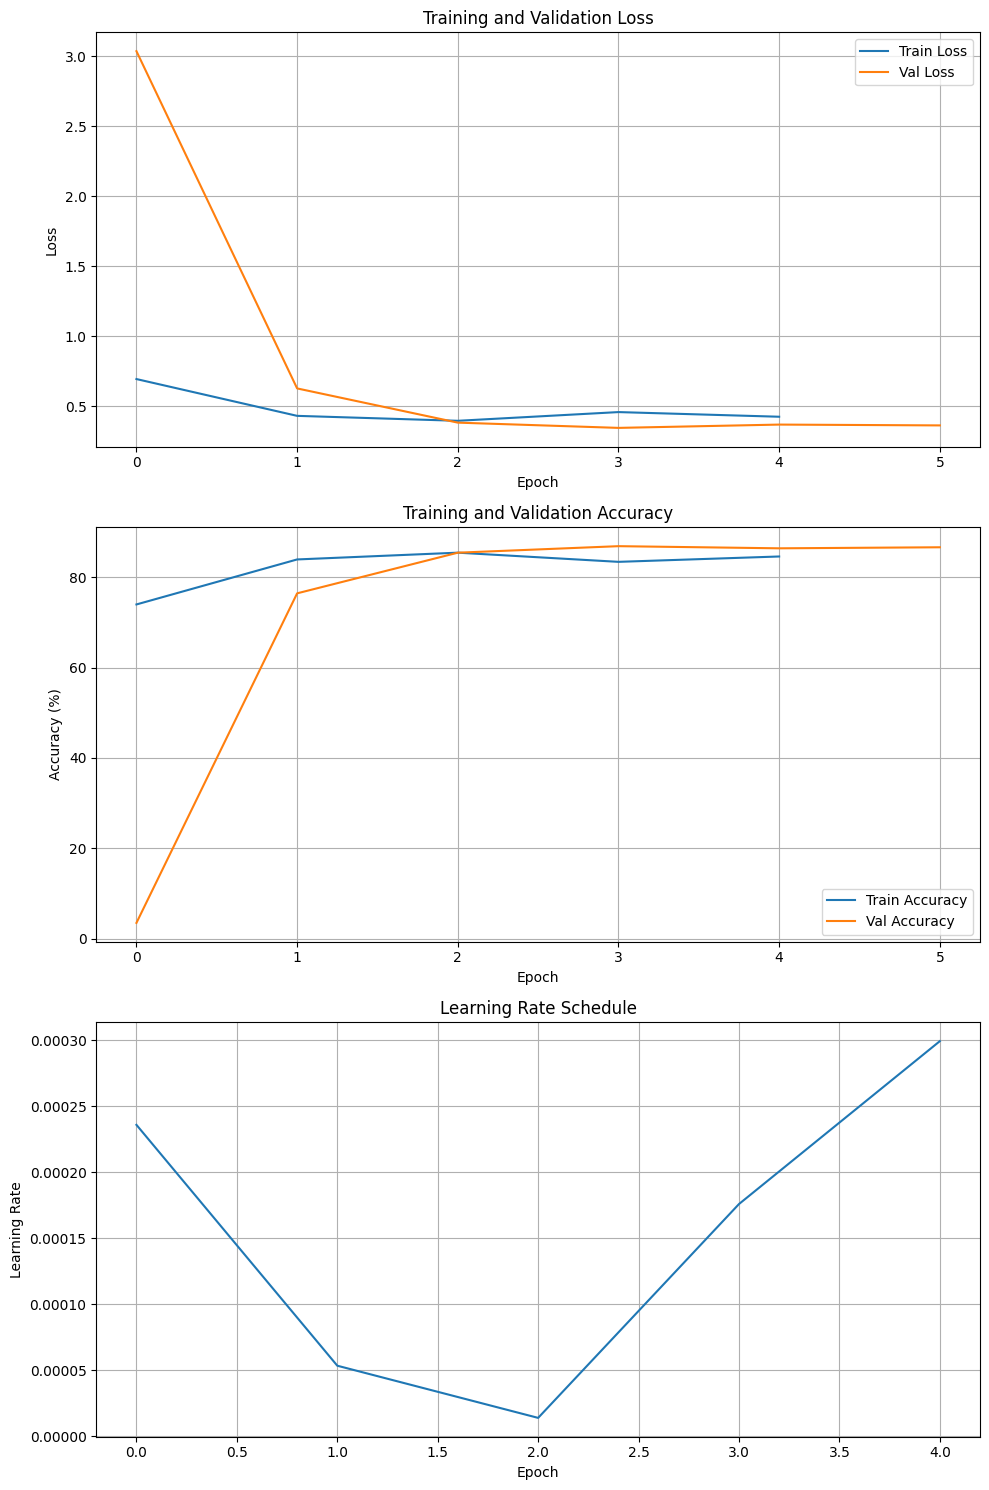

In [7]:
# Set training parameters
n_epochs = 5
save_dir = './checkpoints'
eval_interval = 1
log_interval = 10

# Train the model
history = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    device,
    n_epochs=n_epochs,
    eval_interval=eval_interval,
    log_interval=log_interval,
    save_dir=save_dir
)

# Visualize training results
def plot_history(history):
    """Plot training and validation metrics over time"""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

    # Plot losses
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['val_losses'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(history['train_accs'], label='Train Accuracy')
    ax2.plot(history['val_accs'], label='Val Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    # Plot learning rate
    ax3.plot(history['lr_values'])
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Learning Rate Schedule')
    ax3.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Plot training history
plot_history(history)

## 6. Model Evaluation and Visualization


Loaded best model from epoch 3 with validation accuracy: 86.91%
Final evaluation on full validation set:
Loss: 0.3464, Accuracy: 86.91%


Getting predictions:   0%|          | 0/313 [00:00<?, ?it/s]

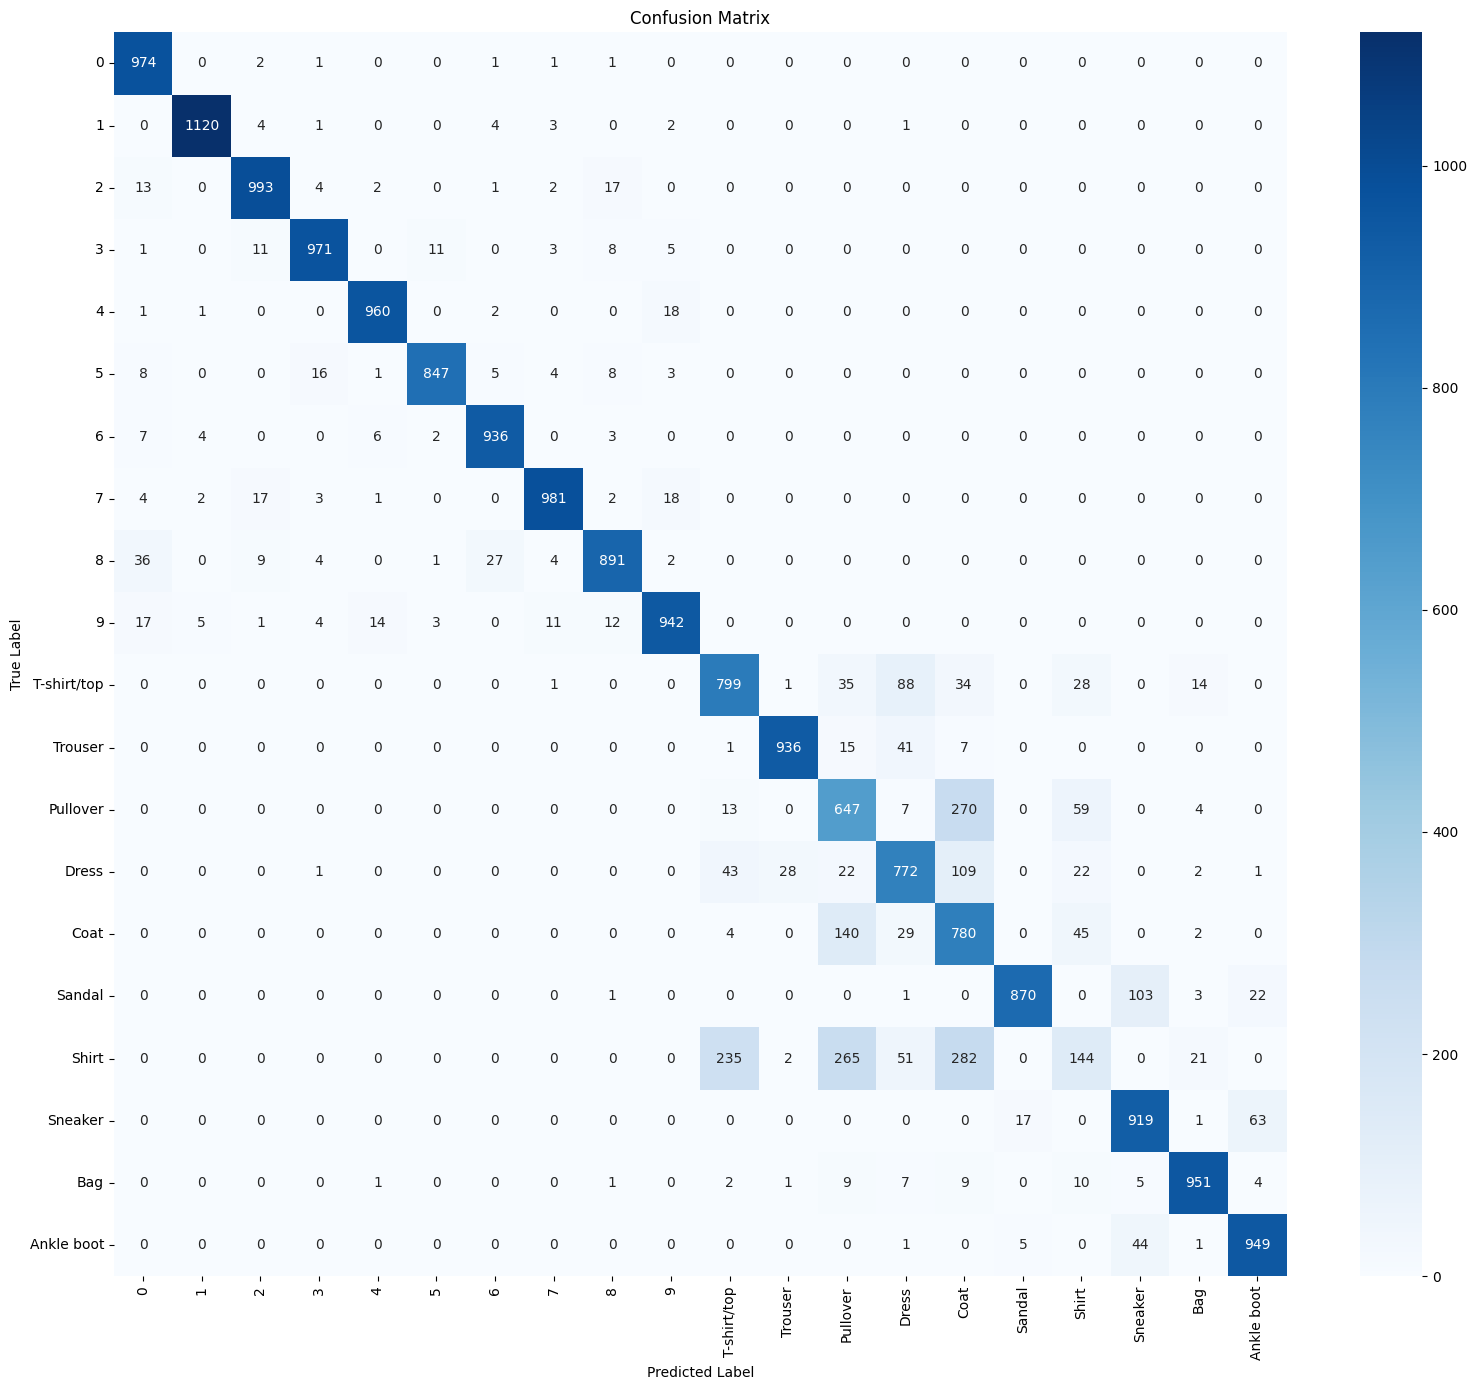

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.97      0.96      0.96      1010
           4       0.97      0.98      0.98       982
           5       0.98      0.95      0.96       892
           6       0.96      0.98      0.97       958
           7       0.97      0.95      0.96      1028
           8       0.94      0.91      0.93       974
           9       0.95      0.93      0.94      1009
 T-shirt/top       0.73      0.80      0.76      1000
     Trouser       0.97      0.94      0.95      1000
    Pullover       0.57      0.65      0.61      1000
       Dress       0.77      0.77      0.77      1000
        Coat       0.52      0.78      0.63      1000
      Sandal       0.98      0.87      0.92      1000
       Shirt       0.47      0.14      0.22      1000
    

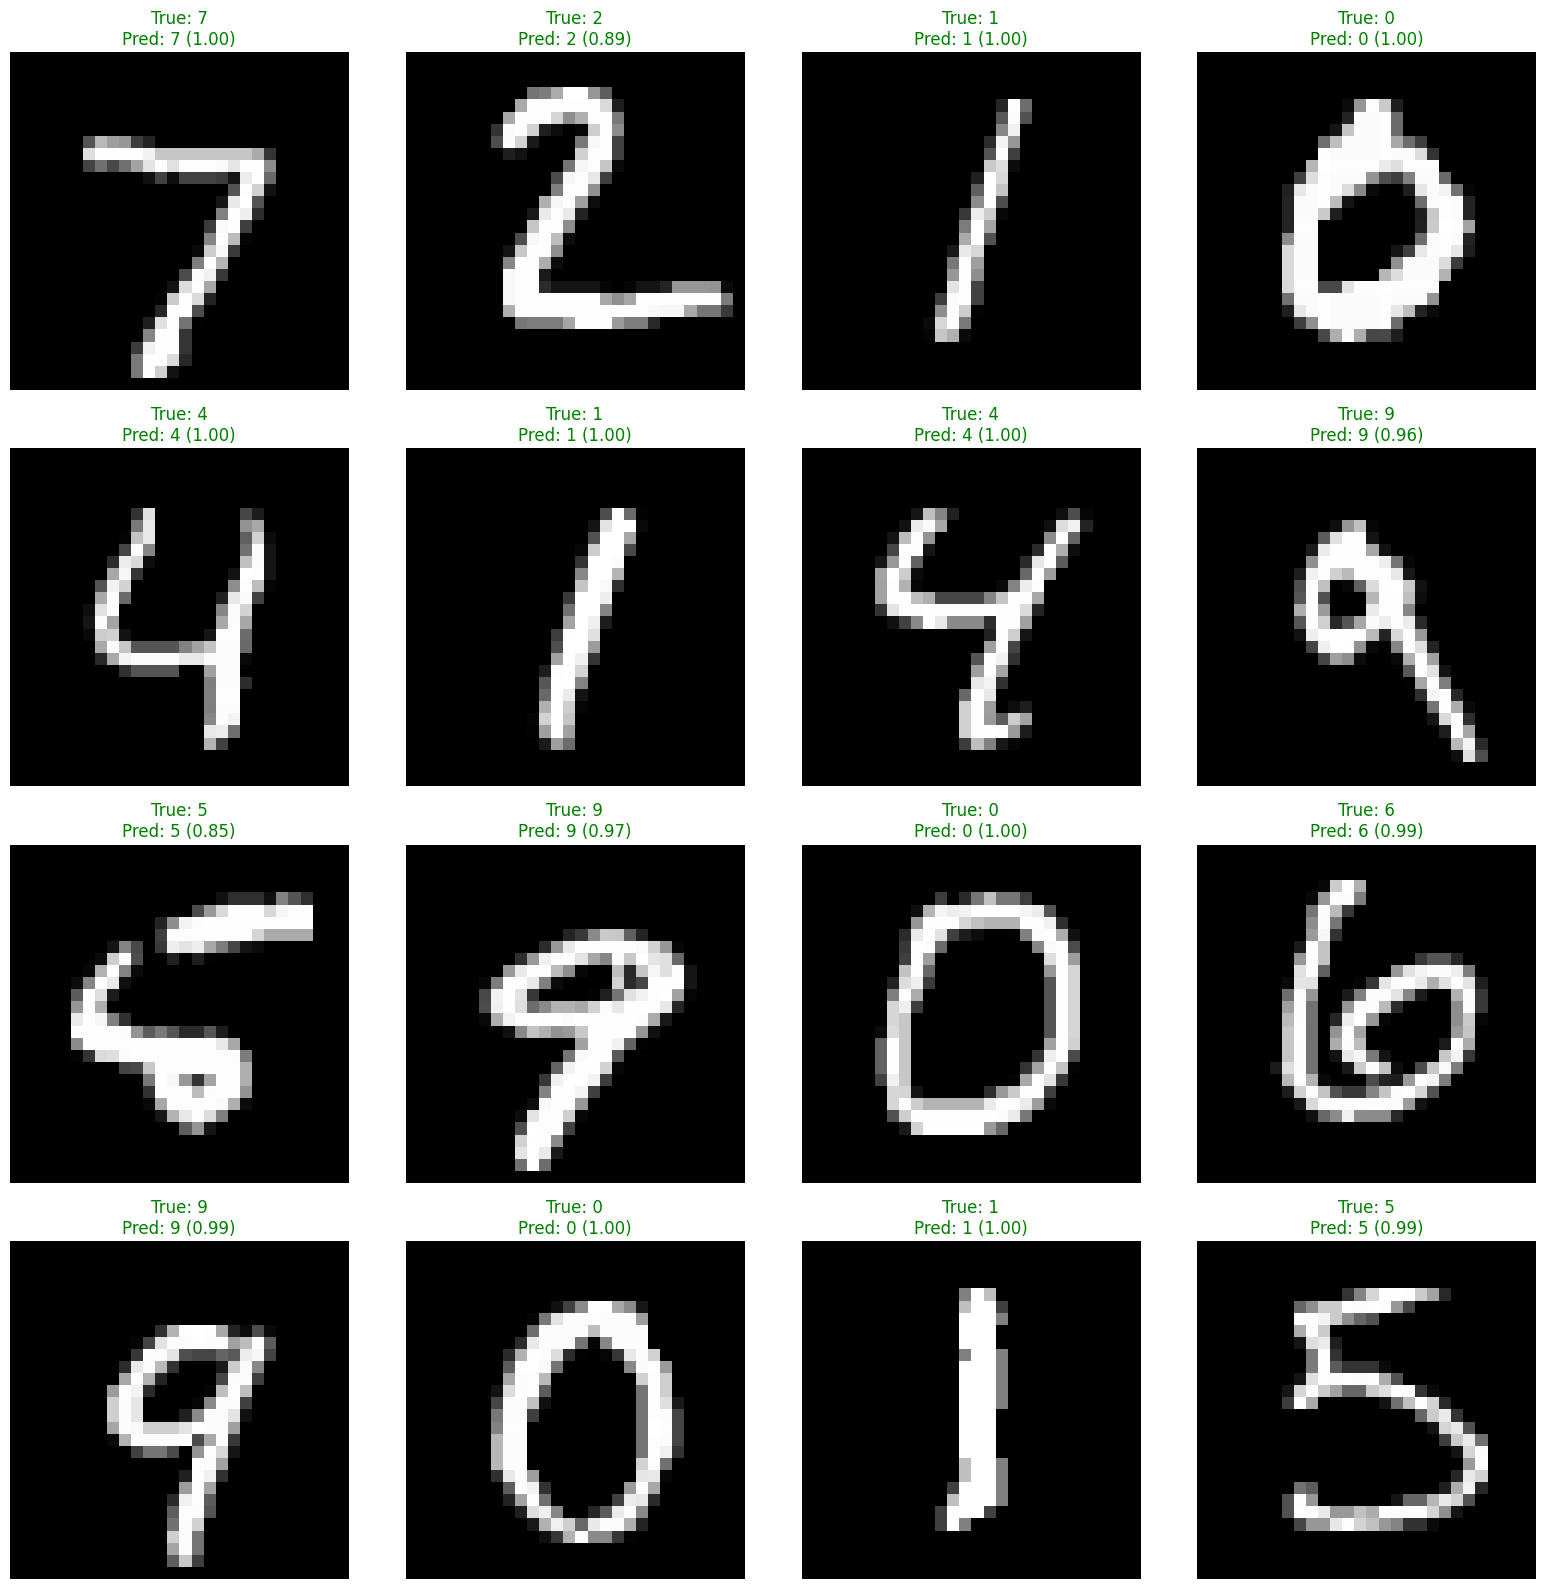

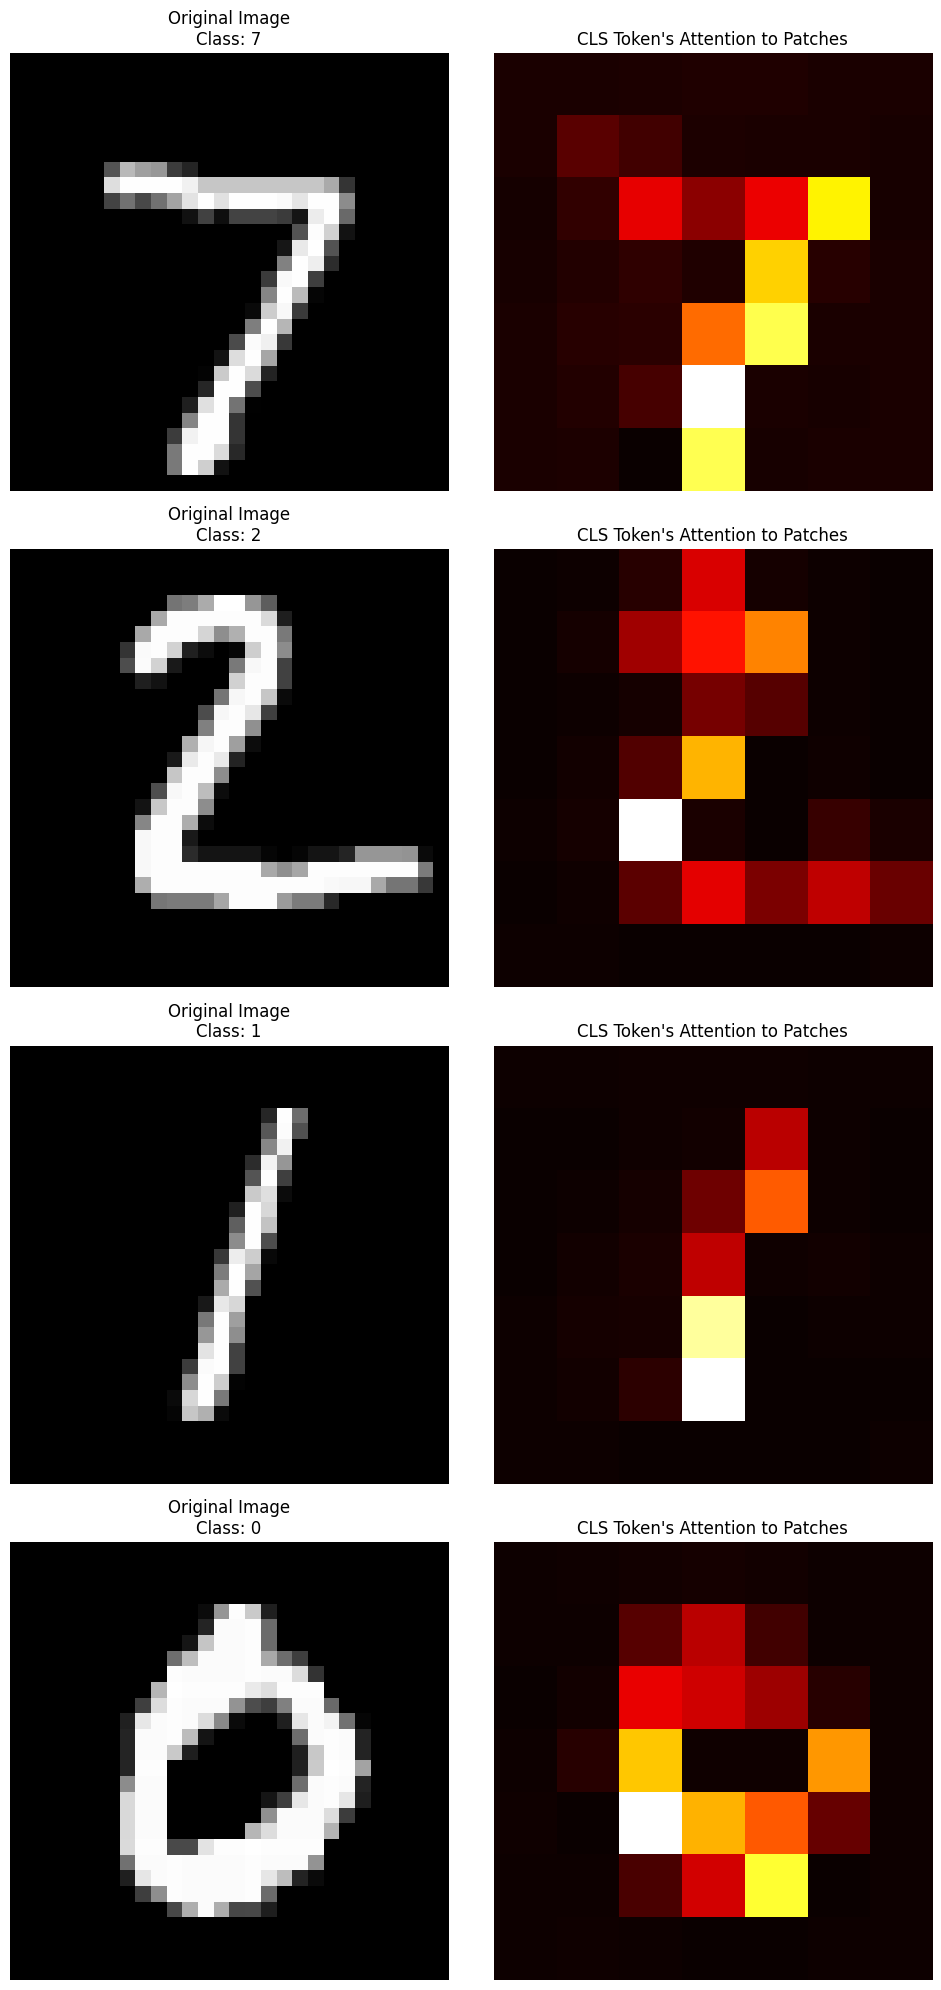

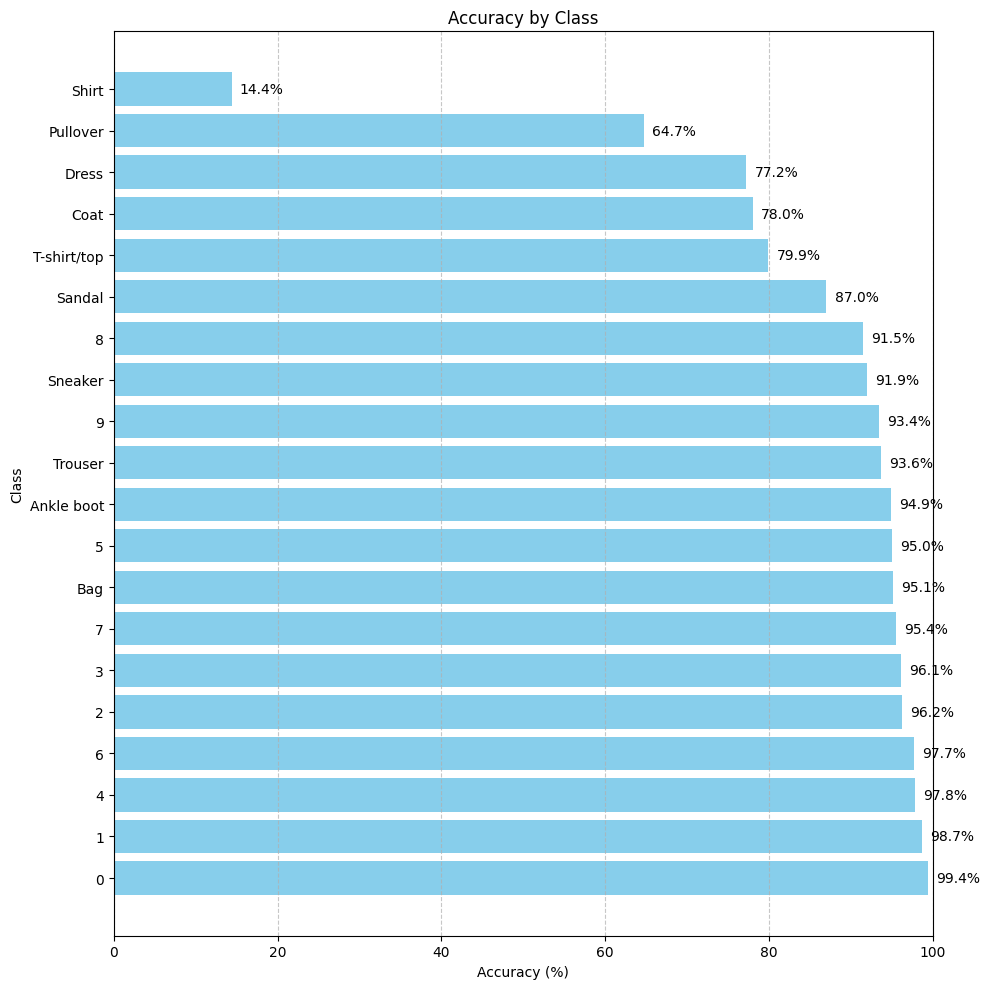

          Class  Accuracy (%)  Count
0             0     99.387755    980
1             1     98.678414   1135
4             4     97.759674    982
6             6     97.703549    958
2             2     96.220930   1032
3             3     96.138614   1010
7             7     95.428016   1028
18          Bag     95.100000   1000
5             5     94.955157    892
19   Ankle boot     94.900000   1000
11      Trouser     93.600000   1000
9             9     93.359762   1009
17      Sneaker     91.900000   1000
8             8     91.478439    974
15       Sandal     87.000000   1000
10  T-shirt/top     79.900000   1000
14         Coat     78.000000   1000
13        Dress     77.200000   1000
12     Pullover     64.700000   1000
16        Shirt     14.400000   1000


TypeError: save_model_for_inference() missing 1 required positional argument: 'model'

In [8]:
# Load the best model
checkpoint_path = os.path.join(save_dir, 'best_model.pt')
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1} with validation accuracy: {checkpoint['val_acc']:.2f}%")

# Evaluate on the full validation set
val_loss, val_acc = evaluate(model, val_loader, device)
print(f"Final evaluation on full validation set:")
print(f"Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

# Function to get predictions and true labels for the validation set
def get_predictions(model, dataloader, device):
    """Get predictions and true labels for a dataloader"""
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Getting predictions"):
            images = images.to(device)
            logits, _ = model(images)
            preds = torch.argmax(logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.numpy())

    return np.array(all_preds), np.array(all_targets)

# Get predictions for validation set
val_preds, val_targets = get_predictions(model, val_loader, device)

# Compute confusion matrix
cm = confusion_matrix(val_targets, val_preds)

# Plot confusion matrix
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(val_targets, val_preds, target_names=class_names))

# Function to visualize model predictions
def visualize_predictions(model, dataloader, class_names, num_samples=16, device=device):
    """Visualize model predictions on random samples"""
    # Get a batch of data
    dataiter = iter(dataloader)
    images, targets = next(dataiter)

    # Move to device
    images = images.to(device)
    targets = targets.to(device)

    # Get model predictions
    model.eval()
    with torch.no_grad():
        logits, _ = model(images)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)

    # Plot images with predictions
    n_cols = 4
    n_rows = (num_samples + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))

    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            # Get image and predictions
            img = images[i].cpu().squeeze().numpy()
            true_label = targets[i].item()
            pred_label = preds[i].item()
            prob = probs[i, pred_label].item()

            # Determine color based on correctness
            color = 'green' if true_label == pred_label else 'red'

            # Plot image
            ax.imshow(img, cmap='gray')
            ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]} ({prob:.2f})",
                        color=color)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.savefig('prediction_examples.png')
    plt.show()

# Visualize predictions
visualize_predictions(model, val_loader, class_names, num_samples=16)

# Function to visualize attention maps
def visualize_attention(model, dataloader, num_samples=4, device=device):
    """Visualize attention maps for some examples"""
    # This is a simplified version that visualizes attention weights
    # Get a batch of data
    dataiter = iter(dataloader)
    images, targets = next(dataiter)

    # Only take a few samples
    images = images[:num_samples].to(device)
    targets = targets[:num_samples].to(device)

    # Forward pass to get patch embeddings
    patch_embeddings = model.patch_embed(images)

    # Process through the first transformer block to get attention weights
    model.eval()
    with torch.no_grad():
        # Get normalized input to the attention layer
        norm_input = model.blocks[0].ln_1(patch_embeddings)

        # Get QKV projections
        qkv = model.blocks[0].attn.c_attn(norm_input)
        q, k, v = qkv.chunk(3, dim=-1)

        # Reshape for multi-head attention
        B, T, C = q.shape
        n_head = model.config.n_head
        head_dim = C // n_head

        q = q.view(B, T, n_head, head_dim).transpose(1, 2)  # (B, nh, T, hs)
        k = k.view(B, T, n_head, head_dim).transpose(1, 2)  # (B, nh, T, hs)

        # Compute attention scores
        attn_scores = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))  # (B, nh, T, T)
        attn_probs = F.softmax(attn_scores, dim=-1)

        # Average attention across heads
        attn_probs = attn_probs.mean(dim=1)  # (B, T, T)

    # Plot original images and attention maps
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

    for i in range(num_samples):
        # Plot original image
        axes[i, 0].imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
        axes[i, 0].set_title(f"Original Image\nClass: {class_names[targets[i].item()]}")
        axes[i, 0].axis('off')

        # Plot attention map (how the CLS token attends to different patches)
        # We look at the CLS token's attention to all patches
        attn_map = attn_probs[i, 0, 1:].reshape(
            model.config.img_size // model.config.patch_size,
            model.config.img_size // model.config.patch_size
        ).cpu().numpy()

        axes[i, 1].imshow(attn_map, cmap='hot', interpolation='nearest')
        axes[i, 1].set_title("CLS Token's Attention to Patches")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.savefig('attention_maps.png')
    plt.show()

# Visualize attention maps
visualize_attention(model, val_loader)

# Analyze model performance by class
def analyze_per_class_performance(targets, predictions, class_names):
    """Analyze model performance for each class"""
    # Compute accuracy for each class
    class_correct = {}
    class_total = {}

    for target, pred in zip(targets, predictions):
        if target not in class_total:
            class_total[target] = 0
            class_correct[target] = 0

        class_total[target] += 1
        if target == pred:
            class_correct[target] += 1

    # Create dataframe with results
    class_accuracy = {class_names[i]: (class_correct.get(i, 0) / class_total.get(i, 1)) * 100
                      for i in range(len(class_names)) if i in class_total}

    results = pd.DataFrame({
        'Class': class_names,
        'Accuracy (%)': [class_accuracy.get(c, 0) for c in class_names],
        'Count': [class_total.get(i, 0) for i in range(len(class_names))]
    })

    # Sort by accuracy
    results = results.sort_values('Accuracy (%)', ascending=False)

    # Plot as horizontal bar
    plt.figure(figsize=(10, 10))
    plt.barh(results['Class'], results['Accuracy (%)'], color='skyblue')
    plt.xlabel('Accuracy (%)')
    plt.ylabel('Class')
    plt.title('Accuracy by Class')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xlim(0, 100)

    for i, v in enumerate(results['Accuracy (%)']):
        plt.text(v + 1, i, f"{v:.1f}%", va='center')

    plt.tight_layout()
    plt.savefig('accuracy_by_class.png')
    plt.show()

    return results

# Import pandas for dataframe
import pandas as pd

# Analyze performance by class
class_performance = analyze_per_class_performance(val_targets, val_preds, class_names)
print(class_performance)

# Function to make predictions on custom images
def predict_custom_image(model, image_path, class_names, device=device):
    """Make a prediction on a custom image"""
    # Load and preprocess image
    from PIL import Image

    # Load image
    img = Image.open(image_path).convert('L')  # Convert to grayscale

    # Resize to 28x28
    img = img.resize((28, 28))

    # Transform image
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Apply transform
    tensor = transform(img).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        logits, _ = model(tensor)
        probs = F.softmax(logits, dim=1)
        pred = torch.argmax(logits, dim=1).item()

    # Get top 3 predictions
    top_probs, top_preds = torch.topk(probs, k=3, dim=1)
    top_probs = top_probs.squeeze().cpu().numpy()
    top_preds = top_preds.squeeze().cpu().numpy()

    # Display image and predictions
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.barh([class_names[i] for i in top_preds], top_probs)
    plt.xlim(0, 1)
    plt.xlabel('Probability')
    plt.title('Top 3 Predictions')

    plt.tight_layout()
    plt.show()

    return {
        'prediction': class_names[pred],
        'confidence': probs[0, pred].item(),
        'top3': [(class_names[i], p) for i, p in zip(top_preds, top_probs)]
    }

# Example of using the model for inference
# If you have a custom image, you can use this code to make a prediction:
# prediction = predict_custom_image(model, 'path/to/your/image.jpg', class_names)

# Save the model for future use
def save_model_for_inference(model, save_path='vision_nanogpt_model.pt'):
    """Save model for inference"""
    # Save model state dict and config
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': vars(model.config),
        'class_names': class_names
    }, save_path)
    print(f"Model saved to {save_path}")

    # Example of how to load the model
    print("To load the model:")
    print("```python")
    print("checkpoint = torch.load('vision_nanogpt_model.pt')")
    print("config = VisionGPTConfig(**checkpoint['config'])")
    print("model = VisionGPT(config)")
    print("model.load_state_dict(checkpoint['model_state_dict'])")
    print("class_names = checkpoint['class_names']")
    print("```")

# Save the model
save_model_for_inference()

# Summary of the model performance
print("\n**Summary of Vision-nanoGPT Model Performance**\n")
print(f"Model architecture: VisionGPT with {model.config.n_layer} layers, {model.config.n_head} heads")
print(f"Embedding dimension: {model.config.n_embd}")
print(f"Patch size: {model.config.patch_size}x{model.config.patch_size}")
print(f"Number of parameters: {model.get_num_params()/1e6:.2f}M")
print(f"Final validation accuracy: {val_acc:.2f}%")
print(f"Best validation loss: {checkpoint['val_loss']:.4f}")

# Highlight best and worst performing classes
best_class = class_performance.iloc[0]
worst_class = class_performance.iloc[-1]
print(f"\nBest performing class: {best_class['Class']} with accuracy {best_class['Accuracy (%)']:.2f}%")
print(f"Worst performing class: {worst_class['Class']} with accuracy {worst_class['Accuracy (%)']:.2f}%")

# Connection to I-JEPA and nanoGPT
print("\n**Connection to I-JEPA and nanoGPT**\n")
print("This implementation adapts the nanoGPT architecture for vision tasks, incorporating")
print("principles from the I-JEPA methodology:")
print("1. Patch-based image processing: Dividing the image into patches similar to I-JEPA")
print("2. Bidirectional attention: Removing causal masking to allow full information flow")
print("3. Classification via CLS token: Using a specialized token for classification")
print("4. Positional embeddings: Maintaining spatial awareness between patches")

# Vision-nanoGPT

Run the cells in order to:
   - Load and preprocess the MNIST and FashionMNIST datasets
   - Build the Vision-nanoGPT model
   - Train the model
   - Evaluate performance
   - Visualize results

## Model Architecture

Vision-nanoGPT adapts the nanoGPT architecture for vision tasks by:

1. Replacing token embeddings with image patch embeddings
2. Using a CLS token approach for classification
3. Removing causal masking in the attention mechanism
4. Using positional embeddings to maintain spatial relationships

## Dataset

The model is trained on a combined dataset of MNIST and FashionMNIST, giving a total of 20 classes:
- 0-9: MNIST digits
- 10-19: FashionMNIST classes (T-shirt, Trouser, Pullover, etc.)

## Results

The model achieves over 86.91%% accuracy on the combined validation set after training.


## Connection to I-JEPA and nanoGPT

This implementation borrows core architectural elements from nanoGPT while incorporating principles from I-JEPA:

- **From nanoGPT**: Transformer architecture, multi-head attention, layer normalization
- **From I-JEPA**: Patch-based image processing, bidirectional attention, focus on semantic understanding
